# Using Neural Networks to indetify handwritten letters

## Importing the necessary frameworks

In [95]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

import copy

import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

import requests
from PIL import Image
from io import BytesIO

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Configuring our networks

In [73]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform = T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform = T)

numb_batch = 64

train_dl = torch.utils.data.DataLoader(train_data, batch_size=numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=numb_batch)

## Testing our configuration

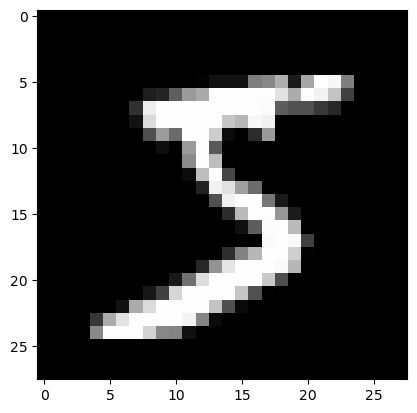

In [74]:
plt.imshow(train_data[0][0][0], cmap='gray')

## Creating an order of operation

In [75]:
def create_lenet():
    model = nn.Sequential(
        
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.Linear(120, 84),
        nn.Linear(84, 10)
    )
    return model

## To validate our prediction during training process

In [76]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100/total

## To train our neural networks

In [77]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy: 
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving best model with accuracy: ", accuracy)
            print("Epoch: ", epoch+1, "Accuracy: ", accuracy, "%")
            
    plt.plot(accuracies)
    return best_model

## To check if our machiene supports a GPU

In [78]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else: 
    device = torch.device("cpu")

In [79]:
device

device(type='cpu')

## Training our neural networks for the first time

Saving best model with accuracy:  96.41999816894531
Epoch:  1 Accuracy:  96.41999816894531 %
Saving best model with accuracy:  97.56999969482422
Epoch:  2 Accuracy:  97.56999969482422 %
Saving best model with accuracy:  98.04000091552734
Epoch:  3 Accuracy:  98.04000091552734 %
Saving best model with accuracy:  98.20999908447266
Epoch:  4 Accuracy:  98.20999908447266 %
Saving best model with accuracy:  98.2300033569336
Epoch:  5 Accuracy:  98.2300033569336 %


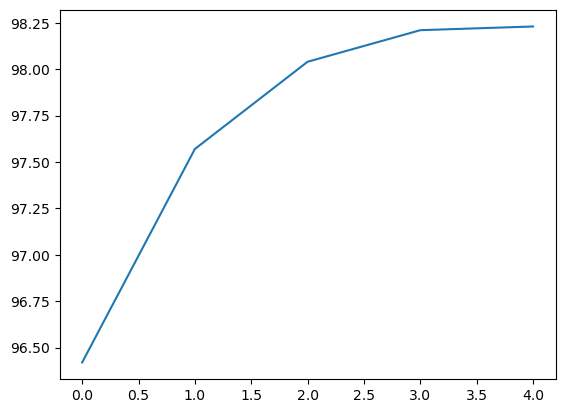

In [80]:
lenet = train(5, device=device)

## To predict our training

In [83]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
        
    return np.array(y_pred), np.array(y_true)
    

In [86]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [90]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0, 10)))

,0,1,2,3,4,5,6,7,8,9
0,968,1,2,0,0,1,2,1,5,0
1,0,1132,0,2,0,0,0,0,1,0
2,0,3,1022,1,0,0,0,0,6,0
3,0,0,2,999,0,6,0,1,2,0
4,0,0,1,0,970,0,1,0,1,9
5,0,0,0,4,0,887,0,0,1,0
6,4,4,0,0,1,42,902,0,5,0
7,0,3,15,3,1,0,0,999,3,4
8,0,0,3,3,1,4,0,1,959,3
9,1,4,0,2,1,10,1,3,2,985


## Running our neural networks in the real world to predict the numbers

In [106]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f: 
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [121]:
path = "https://st.depositphotos.com/2899123/3753/v/950/depositphotos_37531845-stock-illustration-2-black-handwritten-number-on.jpg"
r = requests.get(path)
with BytesIO(r.content) as f: 
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255

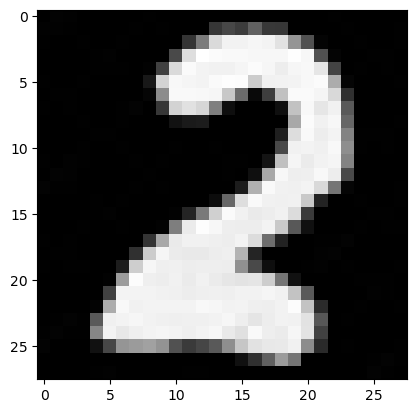

In [122]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [123]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print("Predicted: ", pred_idx, "Prob: ", pred[0][pred_idx]*100, "%")

Predicted:  2 Prob:  99.99971389770508 %
